In [3]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType,DoubleType, DateType
from datetime import date
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
schema = StructType([
StructField("order_id", StringType()),
StructField("region", StringType()),
StructField("category", StringType()),
StructField("quantity", IntegerType()),
StructField("price", DoubleType()),
StructField("order_date", DateType())
])
data = [
("O001", "South", "Electronics", 3, 15000.0, date(2025, 1, 5)),

("O002", "North", "Clothing", 5, 2000.0, date(2025, 1, 6)),
("O003", "East", "Furniture", 2, 12000.0, date(2025, 1, 7)),
("O004", "West", "Electronics", 1, 18000.0, date(2025, 1, 8)),
("O005", "North", "Furniture", 4, 9000.0, date(2025, 1, 10)),
("O006", "South", "Clothing", 6, 2500.0, date(2025, 1, 11)),
("O007", "East", "Electronics", 2, 17000.0, date(2025, 1, 12)),
("O008", "South", "Furniture", 5, 8500.0, date(2025, 1, 15)),
("O009", "West", "Clothing", 7, 3000.0, date(2025, 1, 17)),
("O010", "North", "Electronics", 4, 16000.0, date(2025, 1, 18))
]
df = spark.createDataFrame(data, schema)
df.show()

+--------+------+-----------+--------+-------+----------+
|order_id|region|   category|quantity|  price|order_date|
+--------+------+-----------+--------+-------+----------+
|    O001| South|Electronics|       3|15000.0|2025-01-05|
|    O002| North|   Clothing|       5| 2000.0|2025-01-06|
|    O003|  East|  Furniture|       2|12000.0|2025-01-07|
|    O004|  West|Electronics|       1|18000.0|2025-01-08|
|    O005| North|  Furniture|       4| 9000.0|2025-01-10|
|    O006| South|   Clothing|       6| 2500.0|2025-01-11|
|    O007|  East|Electronics|       2|17000.0|2025-01-12|
|    O008| South|  Furniture|       5| 8500.0|2025-01-15|
|    O009|  West|   Clothing|       7| 3000.0|2025-01-17|
|    O010| North|Electronics|       4|16000.0|2025-01-18|
+--------+------+-----------+--------+-------+----------+



In [27]:
#1. Load the dataset into a PySpark DataFrame and display the first 10 rows.
df.show(10)
#2. Create a new column revenue = quantity × price
from pyspark.sql.functions import col, expr
df = df.withColumn("revenue", col("quantity") * col("price"))
df.show()


save_path = "/dbfs/FileStore/tables/sales_viz/"

+--------+------+-----------+--------+-------+----------+-------+--------+------------------+
|order_id|region|   category|quantity|  price|order_date|revenue|discount|discounted_revenue|
+--------+------+-----------+--------+-------+----------+-------+--------+------------------+
|    O001| South|Electronics|       3|15000.0|2025-01-05|45000.0|     0.1|           40500.0|
|    O002| North|   Clothing|       5| 2000.0|2025-01-06|10000.0|    0.05|            9500.0|
|    O003|  East|  Furniture|       2|12000.0|2025-01-07|24000.0|    0.08|           22080.0|
|    O004|  West|Electronics|       1|18000.0|2025-01-08|18000.0|     0.1|           16200.0|
|    O005| North|  Furniture|       4| 9000.0|2025-01-10|36000.0|    0.08|           33120.0|
|    O006| South|   Clothing|       6| 2500.0|2025-01-11|15000.0|    0.05|           14250.0|
|    O007|  East|Electronics|       2|17000.0|2025-01-12|34000.0|     0.1|           30600.0|
|    O008| South|  Furniture|       5| 8500.0|2025-01-15|425

In [30]:
import os

save_path = "/dbfs/FileStore/tables/sales_viz/"
os.makedirs(save_path, exist_ok=True)

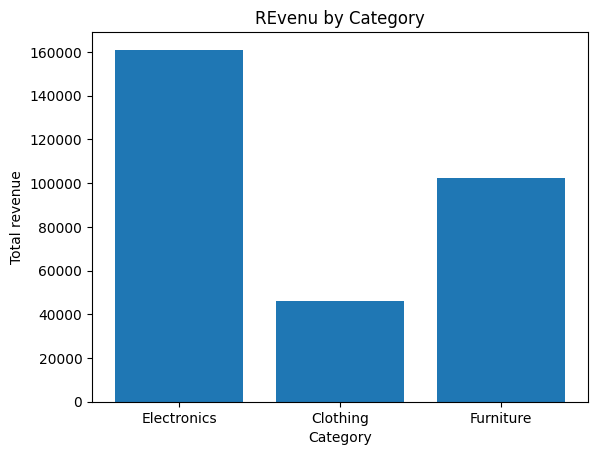

In [31]:
#3. Generate a bar chart showing total revenue by category.
from pyspark.sql.functions import sum as _sum
category_summary = df.groupBy("category").agg(_sum("revenue").alias("total_revenue"))
pdf=category_summary.toPandas()
plt.bar(pdf["category"],pdf["total_revenue"])
plt.xlabel("Category")
plt.ylabel("Total revenue")
plt.title("REvenu by Category")
plt.savefig(f"{save_path}totalrevenuebycategory.png")
plt.show()

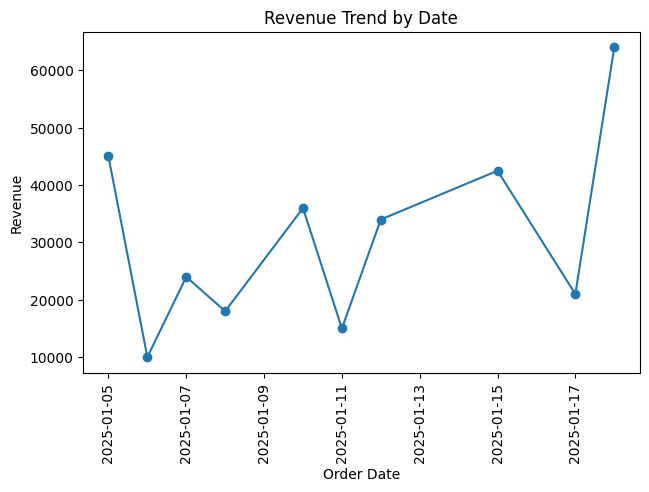

In [32]:
#4. Create a line chart showing revenue trend by order_date (sorted by date).
import matplotlib.pyplot as plt
trend = df.groupBy("order_date").agg(_sum("revenue").alias("total_revenue")).orderBy("order_date")
pdf = trend.toPandas()
plt.plot(pdf["order_date"], pdf["total_revenue"], marker='o')
plt.xlabel("Order Date")
plt.xticks(rotation=90)
plt.tight_layout()
plt.ylabel("Revenue")
plt.title("Revenue Trend by Date")
plt.savefig(f"{save_path}revenuebyo_dte.png")
plt.show()

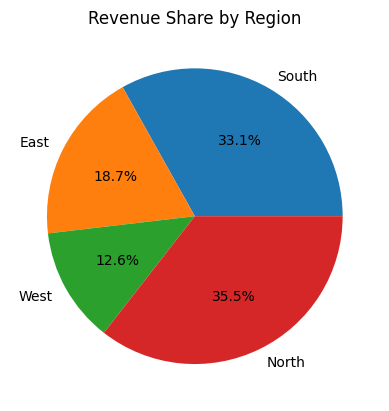

In [33]:
#5. Create a pie chart showing percentage contribution of each region to total revenue.
region_summary = df.groupBy("region").agg(_sum("revenue").alias("total_revenue"))
pdf = region_summary.toPandas()
plt.pie(pdf["total_revenue"], labels=pdf["region"], autopct="%1.1f%%")
plt.title("Revenue Share by Region")
plt.savefig(f"{save_path}percentagecontribution.png")
plt.show()


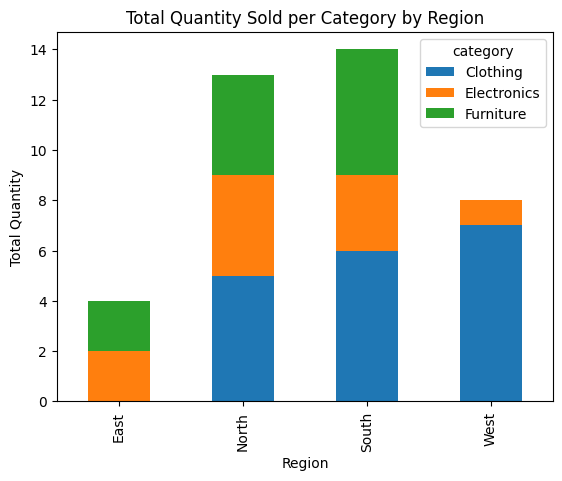

In [34]:
#6. Create a stacked bar chart comparing total quantity sold per category by region.
category_summary = df.groupBy("region", "category").agg(_sum("quantity").alias("total_quantity"))
pdf = category_summary.toPandas()
pivot_df = pdf.pivot(index="region", columns="category", values="total_quantity")
pivot_df.plot(kind="bar", stacked=True)
plt.xlabel("Region")
plt.ylabel("Total Quantity")
plt.title("Total Quantity Sold per Category by Region")
plt.show()


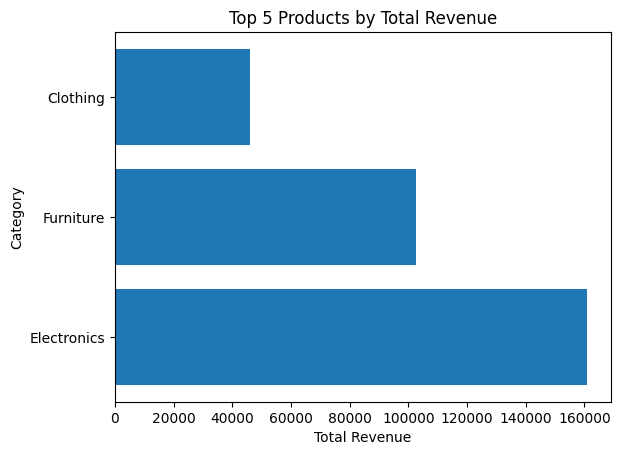

In [35]:
#7. Filter and visualize only top 5 products by total revenue in a horizontal bar chart.
product_summary = df.groupBy("category").agg(_sum("revenue").alias("total_revenue"))
top_products = product_summary.orderBy(col("total_revenue").desc()).limit(5)
pdf = top_products.toPandas()
plt.barh(pdf["category"], pdf["total_revenue"])
plt.xlabel("Total Revenue")
plt.ylabel("Category")
plt.title("Top 5 Products by Total Revenue")
plt.savefig(f"{save_path}totalrevenue_horizontalbc.png")
plt.show()


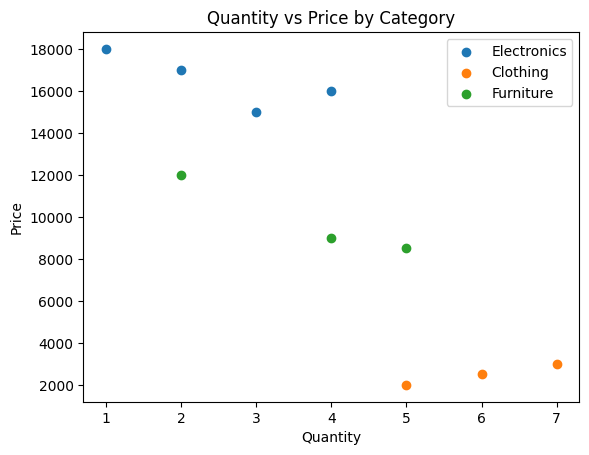

In [36]:
#8. Create a scatter plot showing quantity vs price colored by category .

pdf = df.toPandas()
for cat in pdf["category"].unique():
    subset = pdf[pdf["category"] == cat]
    plt.scatter(subset["quantity"], subset["price"], label=cat)
plt.xlabel("Quantity")
plt.ylabel("Price")
plt.title("Quantity vs Price by Category")
plt.legend()
plt.savefig(f"{save_path}quantityvsprice.png")
plt.show()


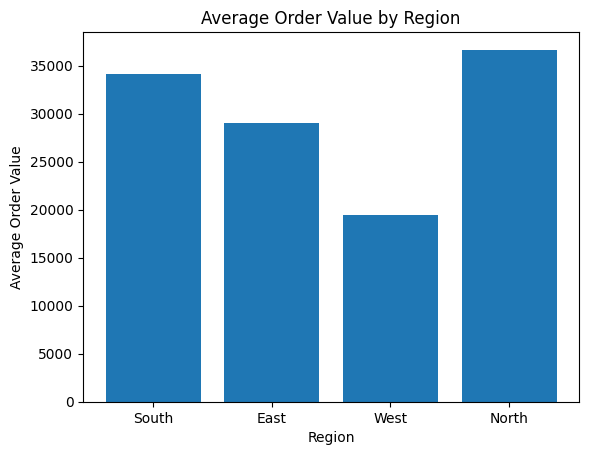

In [37]:
#9. Find average order value by region and plot it as a bar chart.
from pyspark.sql.functions import avg
region_summary = df.groupBy("region").agg(avg("revenue").alias("avg_order_value"))
pdf = region_summary.toPandas()
plt.bar(pdf["region"], pdf["avg_order_value"])
plt.xlabel("Region")
plt.ylabel("Average Order Value")
plt.title("Average Order Value by Region")
plt.savefig(f"{save_path}averageordervalue.png")
plt.show()


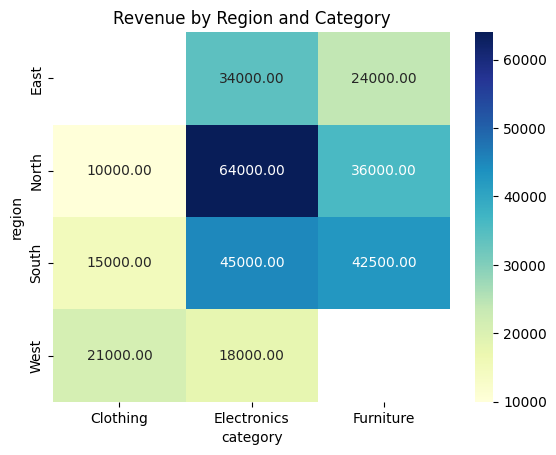

In [38]:
#10. Create a heatmap (pivot table in Databricks) showing revenue by region and category.
import seaborn as sns
from pyspark.sql.functions import sum as _sum
pivot_table = df.groupBy("region", "category").agg(_sum("revenue").alias("total_revenue"))
pdf = pivot_table.toPandas()
pivot_df = pdf.pivot(index="region", columns="category", values="total_revenue")
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Revenue by Region and Category")
plt.savefig(f"{save_path}heatmap.png")
plt.show()


In [26]:

#12. Save all visualizations as PNG files to /dbfs/FileStore/tables/sales_viz/ .
save_path = "/dbfs/FileStore/tables/sales_viz/"




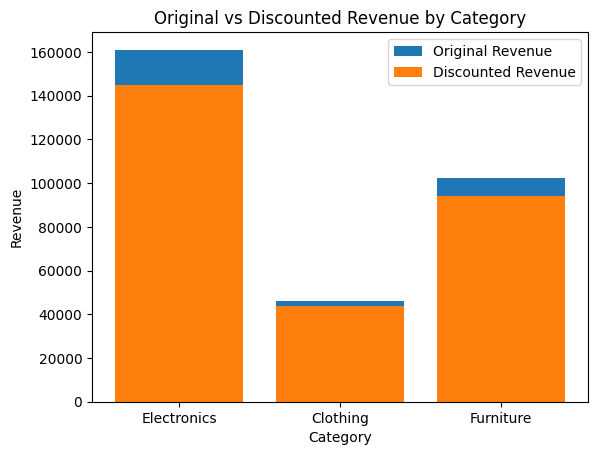

In [39]:
"""11. Bonus: Apply a discount column:
Electronics → 10% discount
Clothing → 5% discount
Furniture → 8% discount Plot discounted vs original revenue for each category
in a grouped bar chart."""
from pyspark.sql.functions import when
df = df.withColumn("discount",
                   when(col("category") == "Electronics", 0.1)
                   .when(col("category") == "Clothing", 0.05)
                   .when(col("category") == "Furniture", 0.08)
                   .otherwise(0))
df = df.withColumn("discounted_revenue", col("revenue") * (1 - col("discount")))
category_summary = df.groupBy("category").agg(
    _sum("revenue").alias("original_revenue"),
    _sum("discounted_revenue").alias("discounted_revenue")
)
pdf = category_summary.toPandas()
plt.bar(pdf["category"], pdf["original_revenue"], label="Original Revenue")
plt.bar(pdf["category"], pdf["discounted_revenue"], label="Discounted Revenue")
plt.xlabel("Category")
plt.ylabel("Revenue")
plt.title("Original vs Discounted Revenue by Category")
plt.legend()
plt.savefig(f"{save_path}discount_grouped.png")
plt.show()


In [40]:
import os
os.listdir(save_path)

['heatmap.png',
 'revenuebyo_dte.png',
 'quantityvsprice.png',
 'averageordervalue.png',
 'discount_grouped.png',
 'totalrevenuebycategory.png',
 'percentagecontribution.png',
 'totalrevenue_horizontalbc.png']